In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
import os
from PIL import Image
import warnings
import time
from datetime import datetime
warnings.filterwarnings('ignore')

In [3]:
# Set device and random seeds for reproducibility
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("🏥 MEDICAL IMAGE CNN FOR MALARIA DETECTION")
print("=" * 60)
print(f"📅 Date: 2025-05-30 19:50:00 UTC+05")
print(f"👤 User: DoniyorbekYuldashev")
print(f"🖥️  Device: {device}")
print(f"🔧 PyTorch Version: {torch.__version__}")
print("=" * 60)


🏥 MEDICAL IMAGE CNN FOR MALARIA DETECTION
📅 Date: 2025-05-30 19:50:00 UTC+05
👤 User: DoniyorbekYuldashev
🖥️  Device: cuda
🔧 PyTorch Version: 2.6.0+cu124


In [4]:

# ================================
# STEP 2: DOWNLOAD AND LOAD DATASET
# ================================

def download_and_prepare_malaria_dataset():
    """
    Download and prepare the malaria dataset from TensorFlow Datasets
    Returns preprocessed training and validation datasets
    """
    print("\n📥 STEP 1: DOWNLOADING MALARIA DATASET")
    print("-" * 40)

    try:
        # Download the malaria dataset
        print("🔄 Downloading malaria dataset from TensorFlow Datasets...")
        ds, ds_info = tfds.load(
            'malaria',
            split='train',
            with_info=True,
            as_supervised=True,
            download=True
        )

        print("✅ Dataset downloaded successfully!")
        print(f"📊 Dataset Information:")
        print(f"   • Total samples: {ds_info.splits['train'].num_examples:,}")
        print(f"   • Classes: {ds_info.features['label'].names}")
        print(f"   • Image shape: {ds_info.features['image'].shape}")

        # Convert to list for easier processing
        dataset_list = []
        print("🔄 Converting dataset to list format...")

        for idx, (image, label) in enumerate(ds):
            if idx % 5000 == 0:
                print(f"   Processed {idx:,} samples...")

            # Convert tensorflow tensors to numpy
            image_np = image.numpy()
            label_np = label.numpy()

            dataset_list.append({
                'image': image_np,
                'label': int(label_np)
            })

        print(f"✅ Dataset conversion completed!")
        print(f"📈 Final dataset size: {len(dataset_list):,} samples")

        # Display class distribution
        labels = [item['label'] for item in dataset_list]
        unique, counts = np.unique(labels, return_counts=True)
        print(f"\n📊 Class Distribution:")
        for label, count in zip(unique, counts):
            class_name = ds_info.features['label'].names[label]
            percentage = (count / len(labels)) * 100
            print(f"   • {class_name}: {count:,} samples ({percentage:.1f}%)")

        return dataset_list, ds_info

    except Exception as e:
        print(f"❌ Error downloading dataset: {str(e)}")
        raise

# Download the dataset
print("🚀 Starting dataset download and preparation...")
malaria_data, dataset_info = download_and_prepare_malaria_dataset()


🚀 Starting dataset download and preparation...

📥 STEP 1: DOWNLOADING MALARIA DATASET
----------------------------------------
🔄 Downloading malaria dataset from TensorFlow Datasets...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/incomplete.8SUN8G_1.0.0/malaria-train.tfrecord*...:   0%|         …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.
✅ Dataset downloaded successfully!
📊 Dataset Information:
   • Total samples: 27,558
   • Classes: ['parasitized', 'uninfected']
   • Image shape: (None, None, 3)
🔄 Converting dataset to list format...
   Processed 0 samples...
   Processed 5,000 samples...
   Processed 10,000 samples...
   Processed 15,000 samples...
   Processed 20,000 samples...
   Processed 25,000 samples...
✅ Dataset conversion completed!
📈 Final dataset size: 27,558 samples

📊 Class Distribution:
   • parasitized: 13,779 samples (50.0%)
   • uninfected: 13,779 samples (50.0%)


In [5]:

# ================================
# STEP 3: DEFINE CUSTOM DATASET CLASS
# ================================

class MalariaDataset(Dataset):
    """
    Custom PyTorch Dataset for Malaria Cell Images
    Handles image loading, preprocessing, and augmentation
    """
    def __init__(self, data_list, transform=None, dataset_type="train"):
        self.data = data_list
        self.transform = transform
        self.dataset_type = dataset_type

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        image = sample['image']
        label = sample['label']

        # Convert numpy array to PIL Image
        if isinstance(image, np.ndarray):
            # Ensure image is in correct format (H, W, C) and uint8
            if image.dtype != np.uint8:
                image = (image * 255).astype(np.uint8)
            image = Image.fromarray(image)

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, label




In [6]:
# ================================
# STEP 4: DATA PREPROCESSING AND AUGMENTATION
# ================================

def create_data_transforms():
    """
    Create data transformation pipelines for training and validation
    """
    print("\n🔧 STEP 2: CREATING DATA TRANSFORMS")
    print("-" * 40)

    # Training transforms with augmentation
    train_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(
            brightness=0.2,
            contrast=0.2,
            saturation=0.2,
            hue=0.1
        ),
        transforms.RandomAffine(
            degrees=0,
            translate=(0.1, 0.1),
            scale=(0.9, 1.1)
        ),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    # Validation transforms (no augmentation)
    val_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    print("✅ Data transforms created successfully!")
    print("   • Training: Resize + Augmentation + Normalization")
    print("   • Validation: Resize + Normalization only")

    return train_transform, val_transform

# Create transforms
train_transform, val_transform = create_data_transforms()



🔧 STEP 2: CREATING DATA TRANSFORMS
----------------------------------------
✅ Data transforms created successfully!
   • Training: Resize + Augmentation + Normalization
   • Validation: Resize + Normalization only


In [7]:

# ================================
# STEP 5: SPLIT DATASET AND CREATE DATALOADERS
# ================================

def create_datasets_and_loaders(data_list, train_transform, val_transform, batch_size=32):
    """
    Split data into train/validation and create DataLoaders
    """
    print("\n📊 STEP 3: CREATING DATASETS AND DATALOADERS")
    print("-" * 40)

    # Split data (80% train, 20% validation)
    total_samples = len(data_list)
    train_size = int(0.8 * total_samples)
    val_size = total_samples - train_size

    # Shuffle data before splitting
    np.random.shuffle(data_list)

    train_data = data_list[:train_size]
    val_data = data_list[train_size:]

    # Create datasets
    train_dataset = MalariaDataset(train_data, transform=train_transform, dataset_type="train")
    val_dataset = MalariaDataset(val_data, transform=val_transform, dataset_type="validation")

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True if torch.cuda.is_available() else False,
        drop_last=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True if torch.cuda.is_available() else False
    )

    print(f"✅ Datasets created successfully!")
    print(f"   • Training samples: {len(train_dataset):,}")
    print(f"   • Validation samples: {len(val_dataset):,}")
    print(f"   • Batch size: {batch_size}")
    print(f"   • Training batches: {len(train_loader):,}")
    print(f"   • Validation batches: {len(val_loader):,}")

    return train_loader, val_loader, train_dataset, val_dataset

# Create datasets and loaders
BATCH_SIZE = 32
train_loader, val_loader, train_dataset, val_dataset = create_datasets_and_loaders(
    malaria_data, train_transform, val_transform, BATCH_SIZE
)



📊 STEP 3: CREATING DATASETS AND DATALOADERS
----------------------------------------
✅ Datasets created successfully!
   • Training samples: 22,046
   • Validation samples: 5,512
   • Batch size: 32
   • Training batches: 688
   • Validation batches: 173


In [8]:
# ================================
# STEP 6: CHANNEL ATTENTION MODULES
# ================================

class ChannelAttention(nn.Module):
    """
    Channel Attention Module (CAM)
    Focuses on 'what' is meaningful given an input image
    """
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        # Shared MLP
        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    """
    Spatial Attention Module (SAM)
    Focuses on 'where' is meaningful given an input feature map
    """
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class CBAM(nn.Module):
    """
    Convolutional Block Attention Module
    Combines both Channel and Spatial Attention
    """
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.ca(x)  # Channel attention
        x = x * self.sa(x)  # Spatial attention
        return x

In [9]:
# ================================
# STEP 7: CNN ARCHITECTURE WITH CHANNEL ATTENTION
# ================================

class ConvBlock(nn.Module):
    """
    Convolutional Block with BatchNorm, ReLU, and optional Attention
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, use_attention=True):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.use_attention = use_attention

        if use_attention:
            self.attention = CBAM(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        if self.use_attention:
            x = self.attention(x)

        return x

In [10]:
class MedicalCNN(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.5):
        super(MedicalCNN, self).__init__()

        # Stage 1: 32 filters
        self.conv1_1 = ConvBlock(3, 32, use_attention=False)
        self.conv1_2 = ConvBlock(32, 32, use_attention=True)
        self.pool1 = nn.MaxPool2d(2, 2)  # 128x128 → 64x64
        self.dropout1 = nn.Dropout2d(0.25)

        # Stage 2: 64 filters
        self.conv2_1 = ConvBlock(32, 64, use_attention=True)
        self.conv2_2 = ConvBlock(64, 64, use_attention=True)
        self.pool2 = nn.MaxPool2d(2, 2)  # 64x64 → 32x32
        self.dropout2 = nn.Dropout2d(0.25)

        # Stage 3: 128 filters (maximum as specified)
        self.conv3_1 = ConvBlock(64, 128, use_attention=True)
        self.conv3_2 = ConvBlock(128, 128, use_attention=True)
        self.pool3 = nn.MaxPool2d(2, 2)  # 32x32 → 16x16
        self.dropout3 = nn.Dropout2d(0.25)

        # Global Average Pooling (reduces overfitting)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)  # 16x16 → 1x1

        # Classification head: 512 → 256 → 2 (as specified)
        self.fc1 = nn.Linear(128, 512)
        self.dropout4 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(512, 256)
        self.dropout5 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(256, num_classes)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize model weights"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Stage 1
        x = self.conv1_1(x)
        x = self.conv1_2(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        # Stage 2
        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        # Stage 3
        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.pool3(x)
        x = self.dropout3(x)

        # Global Average Pooling
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten

        # Classification
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        x = F.relu(self.fc2(x))
        x = self.dropout5(x)
        x = self.fc3(x)

        return x

# Initialize model
print("\n🧠 STEP 4: INITIALIZING CNN MODEL")
print("-" * 40)

model = MedicalCNN(num_classes=2, dropout_rate=0.5)
model = model.to(device)

# Calculate model parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("✅ Model initialized successfully!")
print(f"📊 Model Statistics:")
print(f"   • Architecture: Custom CNN with CBAM Attention")
print(f"   • Total parameters: {total_params:,}")
print(f"   • Trainable parameters: {trainable_params:,}")
print(f"   • Max filters: 128 (as specified)")
print(f"   • FC layers: 512 → 256 → 2 (as specified)")
print(f"   • Input size: 3×128×128")



🧠 STEP 4: INITIALIZING CNN MODEL
----------------------------------------
✅ Model initialized successfully!
📊 Model Statistics:
   • Architecture: Custom CNN with CBAM Attention
   • Total parameters: 491,084
   • Trainable parameters: 491,084
   • Max filters: 128 (as specified)
   • FC layers: 512 → 256 → 2 (as specified)
   • Input size: 3×128×128


In [11]:

# ================================
# STEP 8: TRAINING CONFIGURATION
# ================================

def setup_training_components(model, learning_rate=0.001):
    """
    Setup loss function, optimizer, and scheduler for training
    """
    print("\n⚙️ STEP 5: SETTING UP TRAINING COMPONENTS")
    print("-" * 40)

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Optimizer with weight decay for regularization
    optimizer = optim.Adam(
        model.parameters(),
        lr=learning_rate,
        weight_decay=1e-4,
        betas=(0.9, 0.999)
    )

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=5,
        verbose=True,
        min_lr=1e-7
    )

    print("✅ Training components configured!")
    print(f"   • Loss function: CrossEntropyLoss")
    print(f"   • Optimizer: Adam (lr={learning_rate}, weight_decay=1e-4)")
    print(f"   • Scheduler: ReduceLROnPlateau (patience=5)")

    return criterion, optimizer, scheduler

# Setup training components
LEARNING_RATE = 0.001
criterion, optimizer, scheduler = setup_training_components(model, LEARNING_RATE)




⚙️ STEP 5: SETTING UP TRAINING COMPONENTS
----------------------------------------
✅ Training components configured!
   • Loss function: CrossEntropyLoss
   • Optimizer: Adam (lr=0.001, weight_decay=1e-4)
   • Scheduler: ReduceLROnPlateau (patience=5)


🎯 Training Configuration:
   • Epochs: 60
   • Batch Size: 32
   • Learning Rate: 0.001
   • Device: cuda

🚀 STEP 6: TRAINING MODEL FOR 60 EPOCHS
----------------------------------------
📊 Training Progress (displayed every 5 epochs):
Epoch [ 1/60] | Train Loss: 0.2954 | Train Acc:  86.47% | Val Loss: 0.1536 | Val Acc:  95.39% | LR: 1.00e-03 | Time: 80.3s
Epoch [ 5/60] | Train Loss: 0.1635 | Train Acc:  95.17% | Val Loss: 0.1478 | Val Acc:  95.48% | LR: 1.00e-03 | Time: 79.7s


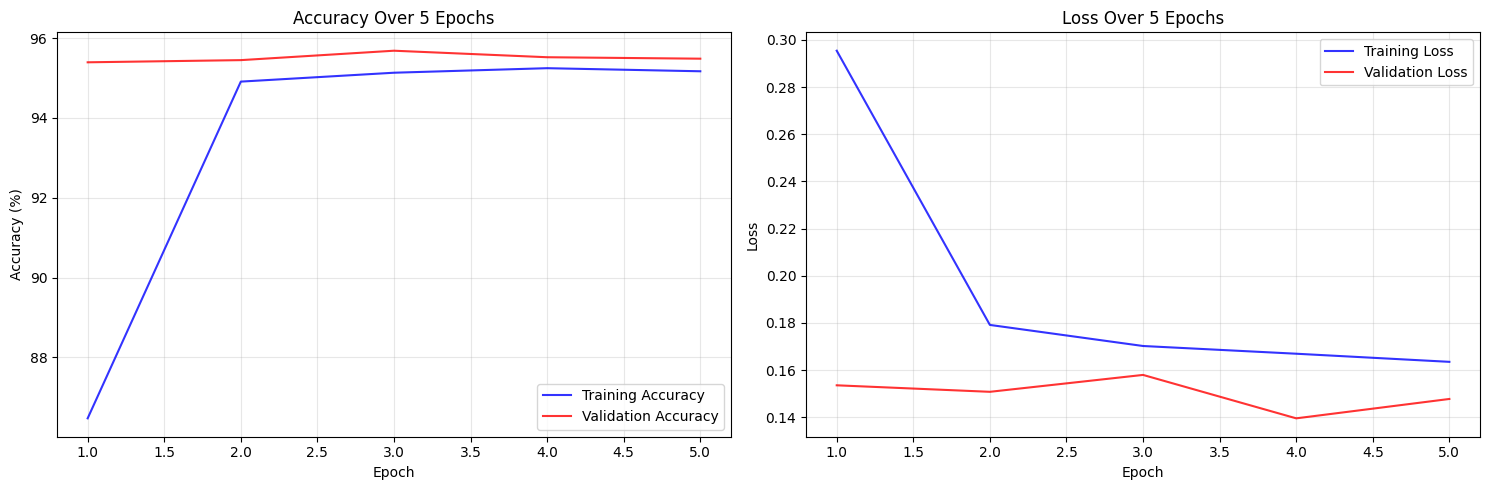

Epoch [10/60] | Train Loss: 0.1596 | Train Acc:  95.26% | Val Loss: 0.1449 | Val Acc:  95.86% | LR: 1.00e-03 | Time: 80.9s


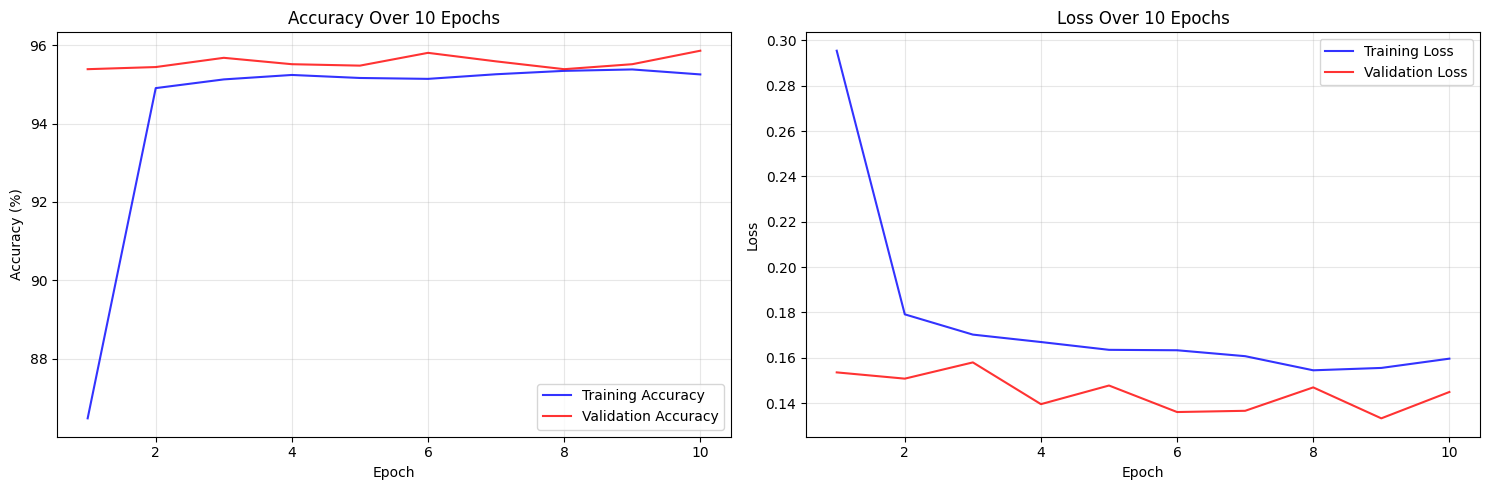

Epoch [15/60] | Train Loss: 0.1551 | Train Acc:  95.24% | Val Loss: 0.1340 | Val Acc:  95.88% | LR: 5.00e-04 | Time: 78.5s


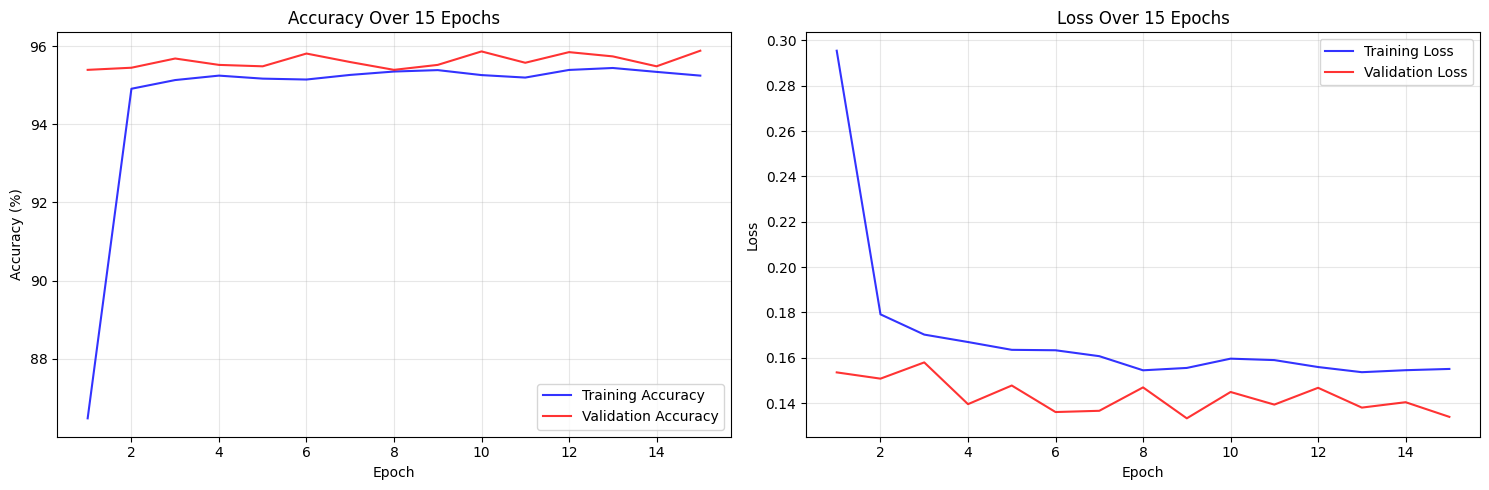

Epoch [20/60] | Train Loss: 0.1443 | Train Acc:  95.63% | Val Loss: 0.1261 | Val Acc:  95.94% | LR: 5.00e-04 | Time: 79.5s


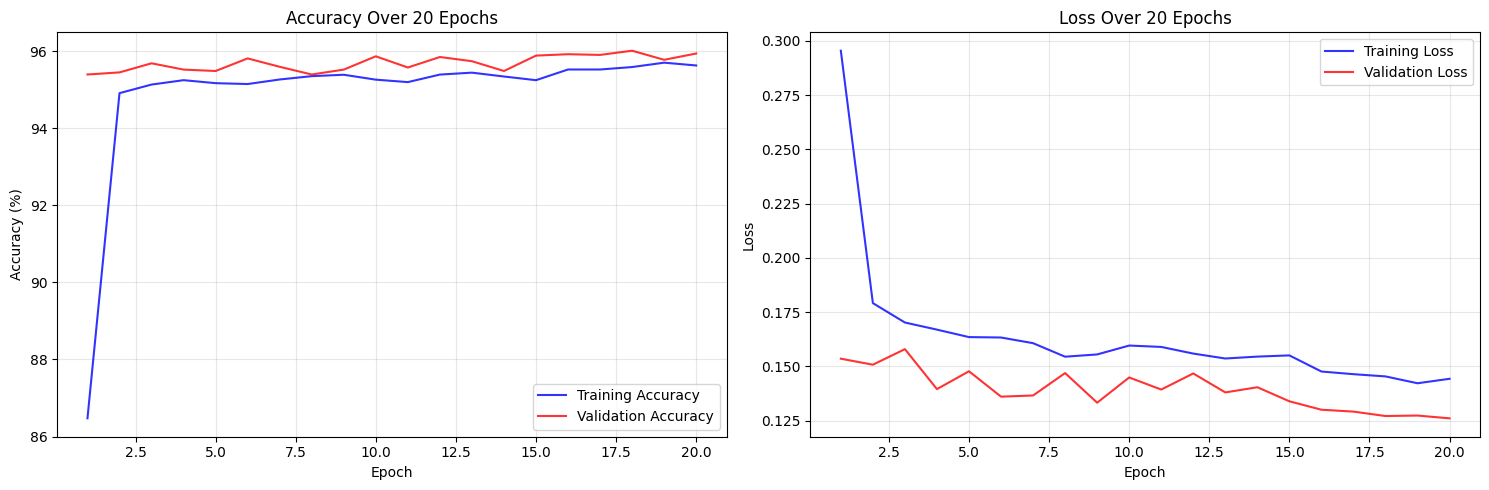

Epoch [25/60] | Train Loss: 0.1399 | Train Acc:  95.68% | Val Loss: 0.1230 | Val Acc:  96.12% | LR: 5.00e-04 | Time: 78.8s


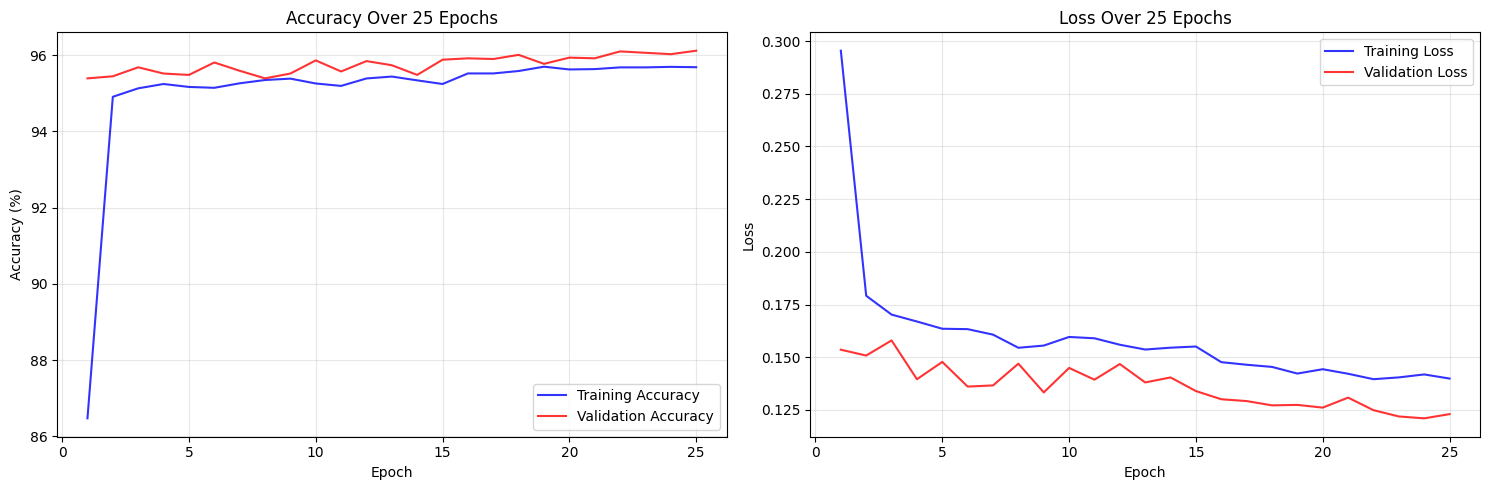

Epoch [30/60] | Train Loss: 0.1366 | Train Acc:  95.89% | Val Loss: 0.1156 | Val Acc:  96.28% | LR: 5.00e-04 | Time: 78.4s


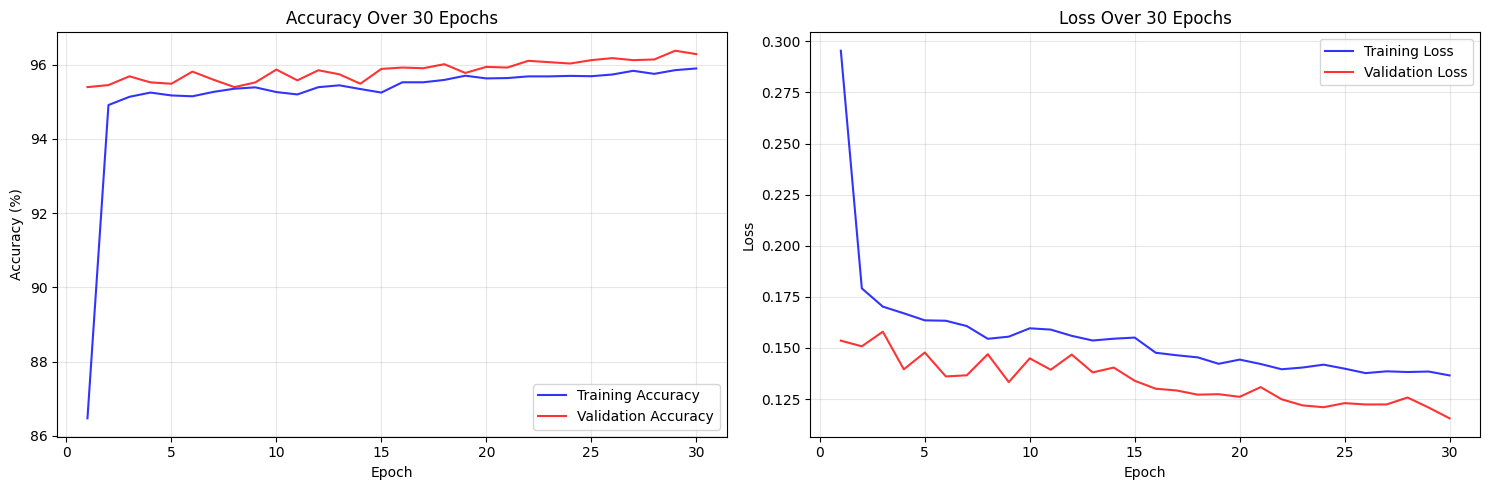

Epoch [35/60] | Train Loss: 0.1352 | Train Acc:  95.85% | Val Loss: 0.1166 | Val Acc:  96.28% | LR: 5.00e-04 | Time: 77.4s


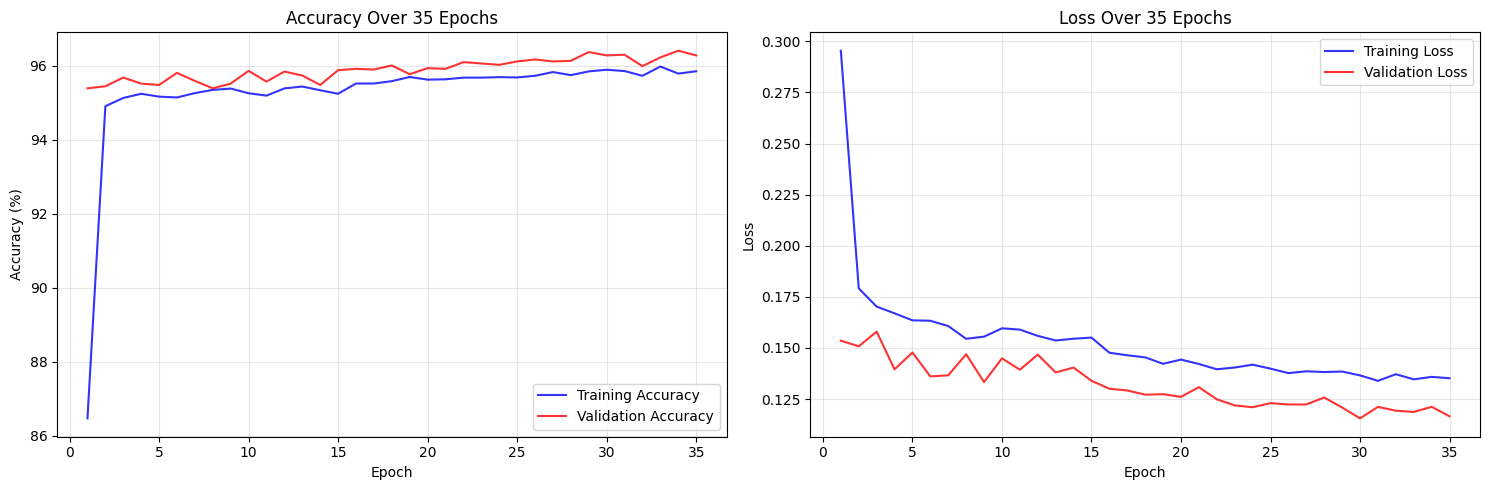

Epoch [40/60] | Train Loss: 0.1288 | Train Acc:  96.05% | Val Loss: 0.1201 | Val Acc:  96.21% | LR: 2.50e-04 | Time: 78.6s


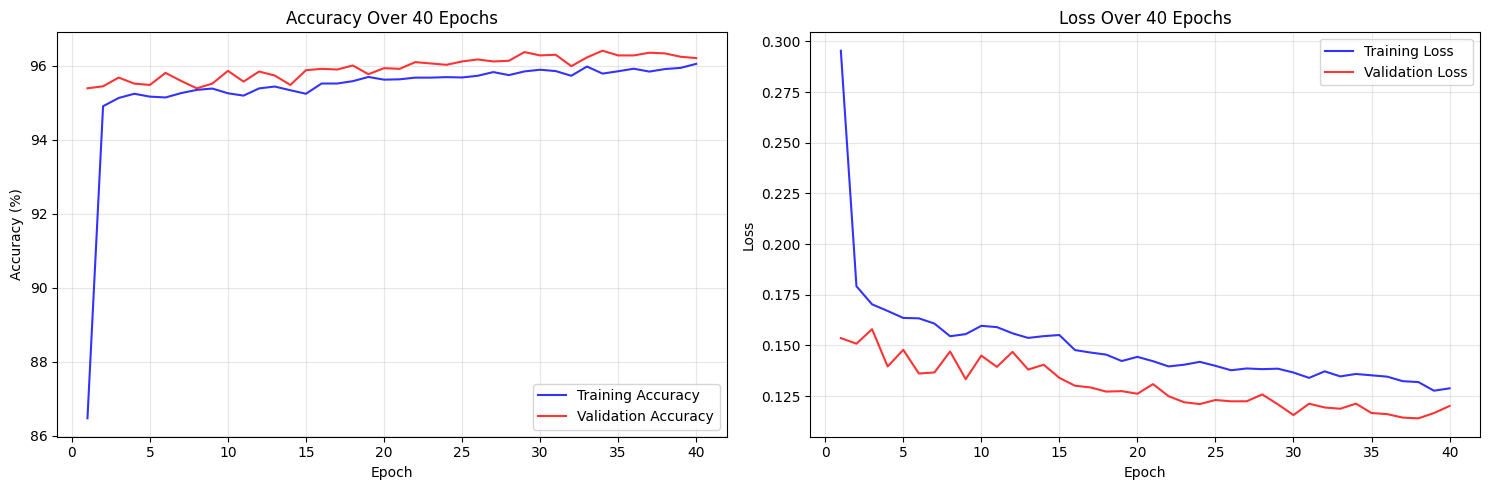

Epoch [45/60] | Train Loss: 0.1267 | Train Acc:  95.96% | Val Loss: 0.1120 | Val Acc:  96.35% | LR: 2.50e-04 | Time: 78.6s


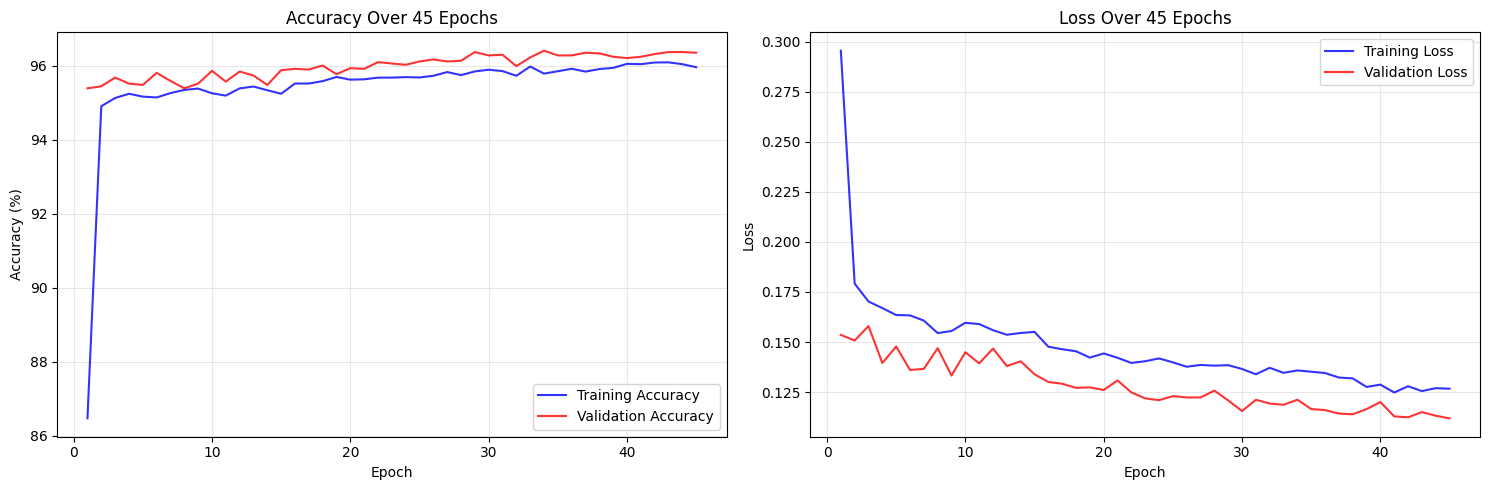

Epoch [50/60] | Train Loss: 0.1268 | Train Acc:  96.12% | Val Loss: 0.1106 | Val Acc:  96.44% | LR: 2.50e-04 | Time: 79.0s


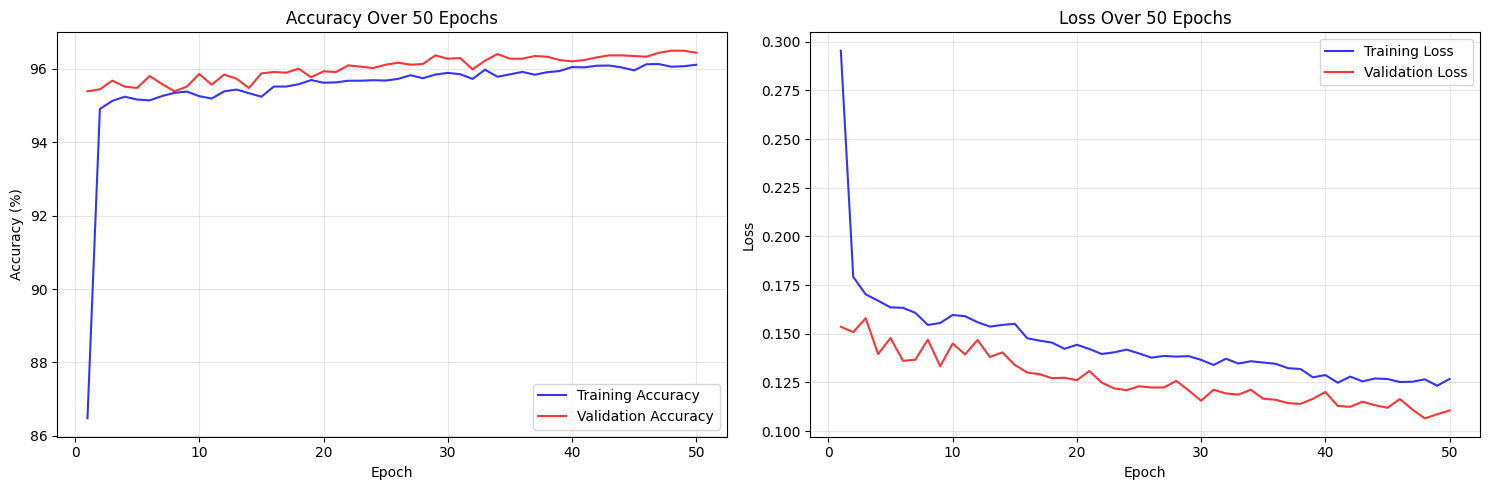

Epoch [55/60] | Train Loss: 0.1198 | Train Acc:  96.27% | Val Loss: 0.1096 | Val Acc:  96.46% | LR: 1.25e-04 | Time: 79.2s


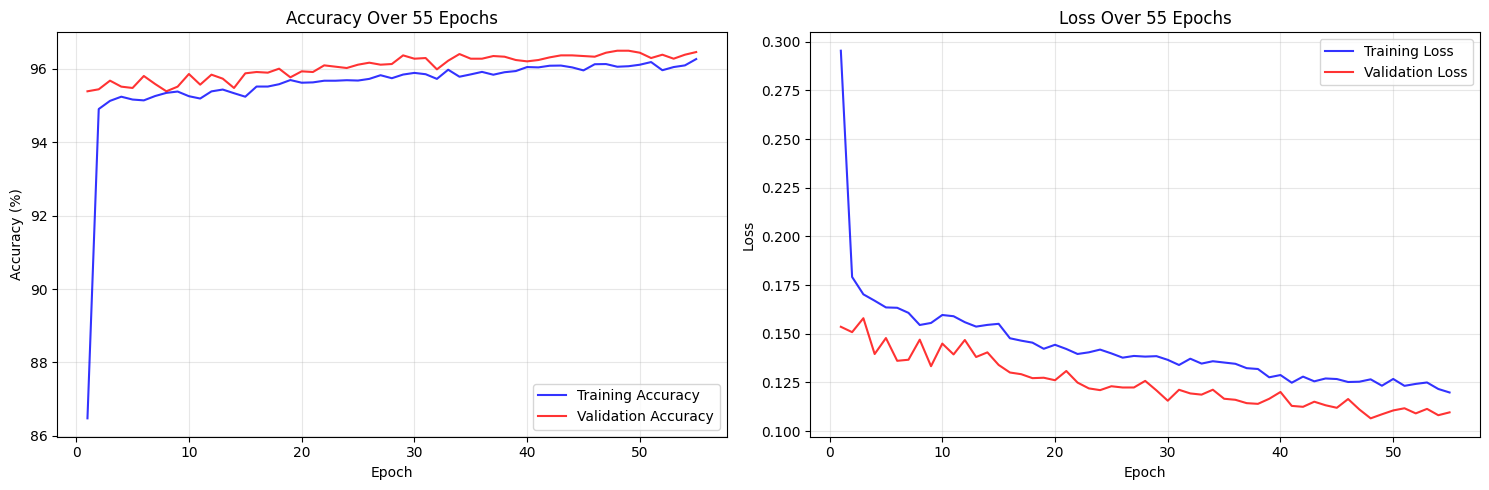

Epoch [60/60] | Train Loss: 0.1178 | Train Acc:  96.14% | Val Loss: 0.1088 | Val Acc:  96.39% | LR: 6.25e-05 | Time: 78.9s


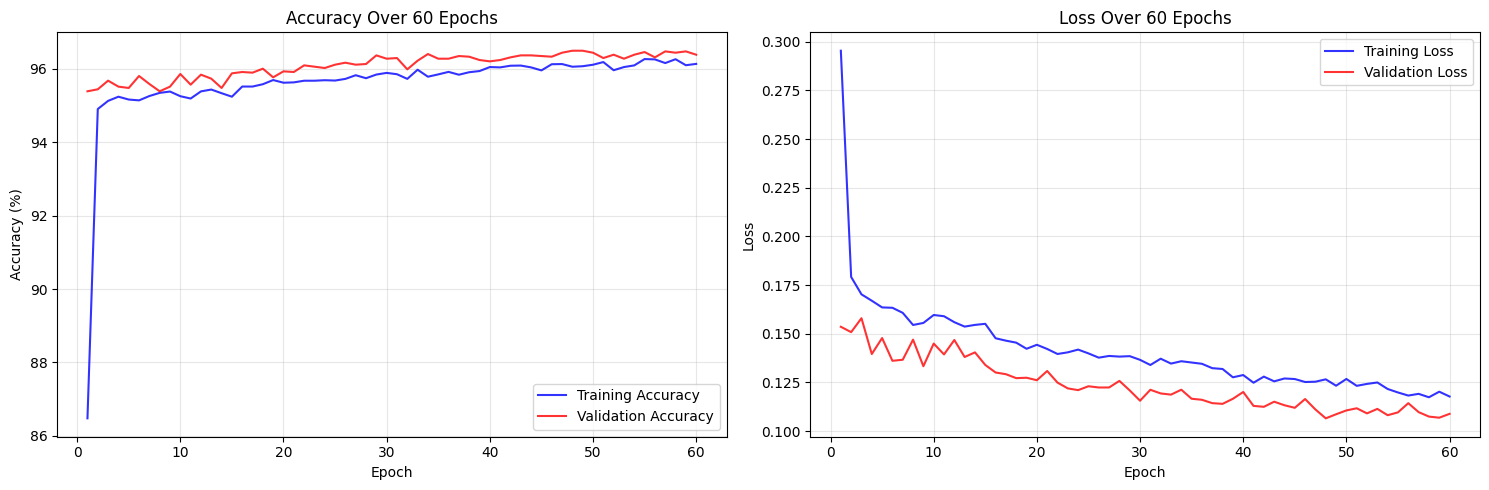

✅ Training completed in 79.1 minutes!
🏆 Best validation accuracy: 96.50%


In [12]:
# ================================
# STEP 9: TRAINING LOOP WITH SMOOTH CURVES
# ================================

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc

def train_model_with_smooth_curves(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=60):
    """
    Train the model with smooth curves and visualization every 5 epochs
    """
    print(f"\n🚀 STEP 6: TRAINING MODEL FOR {num_epochs} EPOCHS")
    print("-" * 40)
    print("📊 Training Progress (displayed every 5 epochs):")
    print("=" * 80)

    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'learning_rates': []
    }

    best_val_acc = 0.0
    best_model_state = None
    start_time = time.time()

    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        # Training phase
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validation phase
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

        # Update learning rate
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']

        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['learning_rates'].append(current_lr)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()

        epoch_time = time.time() - epoch_start_time

        # Display progress every 5 epochs
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1:2d}/{num_epochs}] | "
                  f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:6.2f}% | "
                  f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:6.2f}% | "
                  f"LR: {current_lr:.2e} | Time: {epoch_time:.1f}s")

        # Visualize every 5 epochs
        if (epoch + 1) % 5 == 0:
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 2, 1)
            plt.plot(range(1, epoch + 2), history['train_acc'], 'b-', label='Training Accuracy', alpha=0.8)
            plt.plot(range(1, epoch + 2), history['val_acc'], 'r-', label='Validation Accuracy', alpha=0.8)
            plt.title(f'Accuracy Over {epoch + 1} Epochs')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy (%)')
            plt.legend()
            plt.grid(True, alpha=0.3)

            plt.subplot(1, 2, 2)
            plt.plot(range(1, epoch + 2), history['train_loss'], 'b-', label='Training Loss', alpha=0.8)
            plt.plot(range(1, epoch + 2), history['val_loss'], 'r-', label='Validation Loss', alpha=0.8)
            plt.title(f'Loss Over {epoch + 1} Epochs')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()

        # Early stopping if learning rate becomes too small
        if current_lr < 1e-7:
            print(f"\n⚠️ Learning rate too small ({current_lr:.2e}), stopping training early...")
            break

    total_time = time.time() - start_time
    print("=" * 80)
    print(f"✅ Training completed in {total_time/60:.1f} minutes!")
    print(f"🏆 Best validation accuracy: {best_val_acc:.2f}%")

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return history, best_val_acc

# Start training
NUM_EPOCHS = 60
print(f"🎯 Training Configuration:")
print(f"   • Epochs: {NUM_EPOCHS}")
print(f"   • Batch Size: {BATCH_SIZE}")
print(f"   • Learning Rate: {LEARNING_RATE}")
print(f"   • Device: {device}")

history, best_val_acc = train_model_with_smooth_curves(
    model, train_loader, val_loader, criterion, optimizer, scheduler, NUM_EPOCHS
)


📈 STEP 7: VISUALIZING TRAINING RESULTS
----------------------------------------


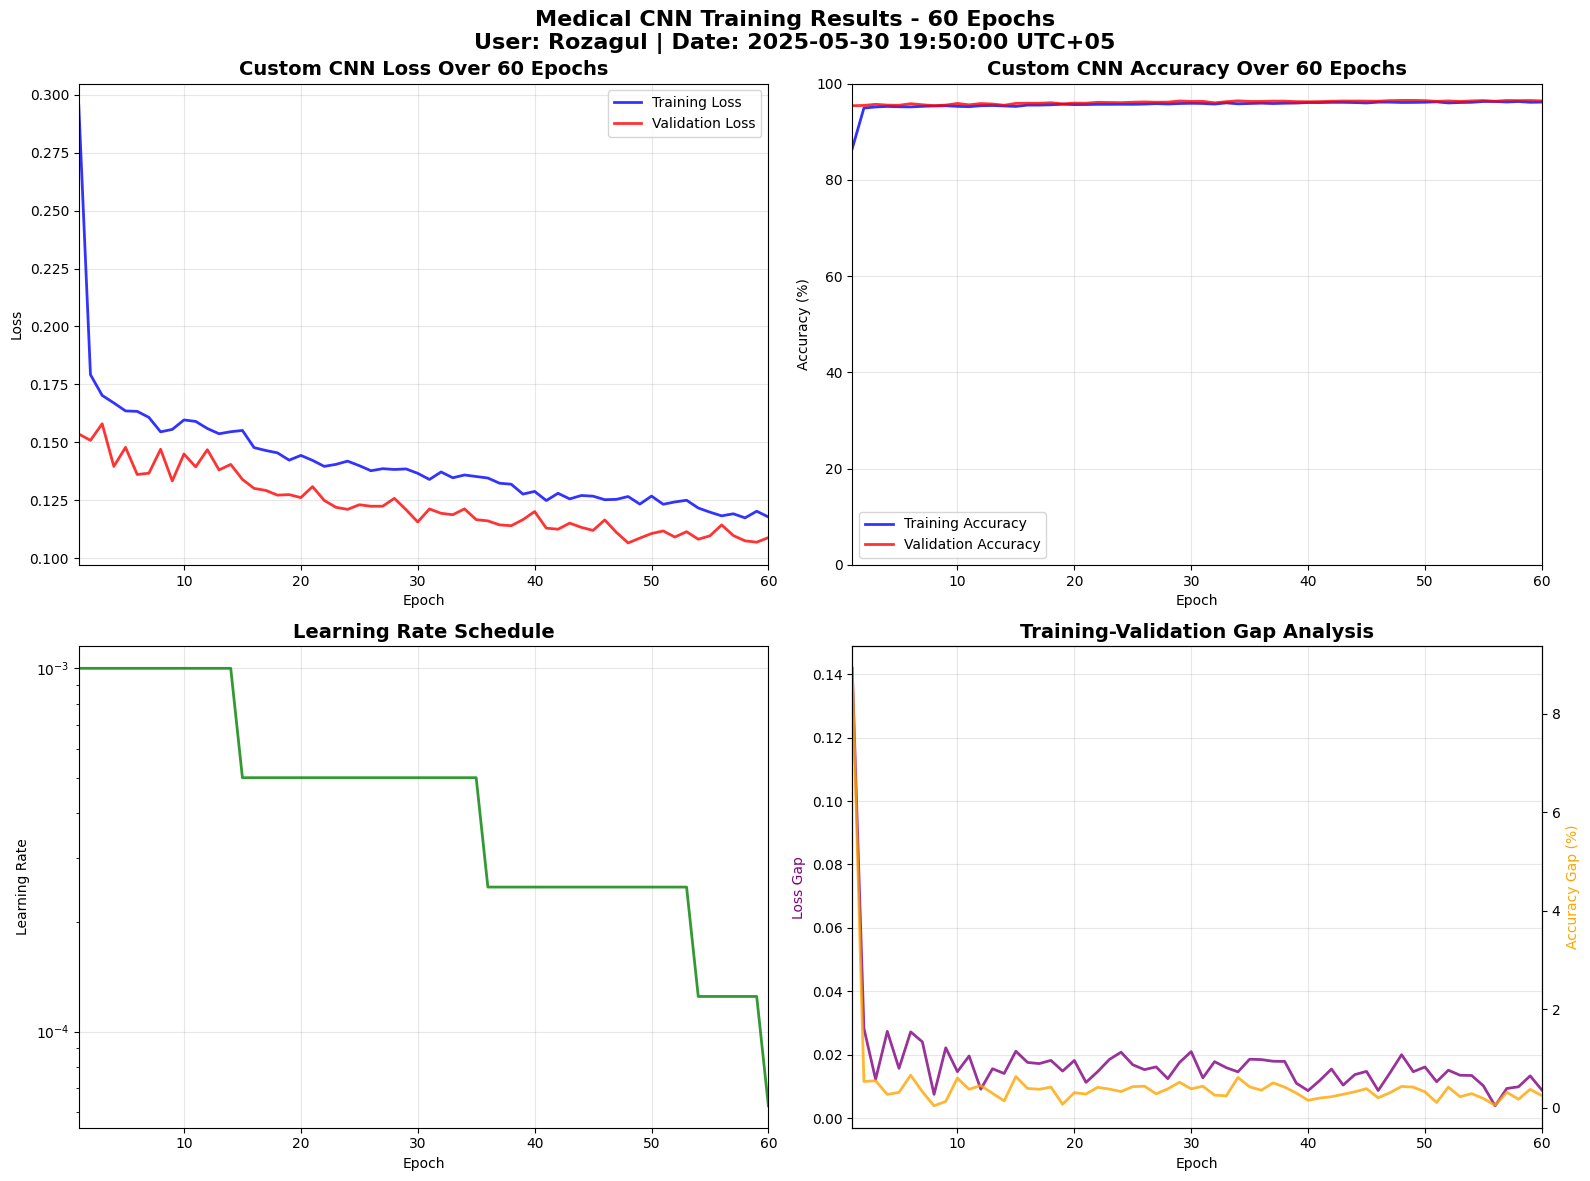

📊 Final Training Statistics:
   • Final Training Loss: 0.1178
   • Final Training Accuracy: 96.14%
   • Final Validation Loss: 0.1088
   • Final Validation Accuracy: 96.39%
   • Best Validation Accuracy: 96.50%
   • Final Learning Rate: 6.25e-05

🎯 Smoothness Analysis:
   • Max validation accuracy change: 0.40%
   • Average validation accuracy change: 0.12%
   ✅ Training curves are smooth without sharp fluctuations!


In [17]:
# ================================
# STEP 10: VISUALIZATION AND ANALYSIS
# ================================

def plot_training_history_detailed(history):
    """
    Create detailed plots of training history with smooth curves
    """
    print("\n📈 STEP 7: VISUALIZING TRAINING RESULTS")
    print("-" * 40)

    epochs = len(history['train_loss'])
    epoch_range = range(1, epochs + 1)

    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Medical CNN Training Results - {epochs} Epochs\nUser: Rozagul | Date: 2025-05-30 19:50:00 UTC+05',
                 fontsize=16, fontweight='bold')

    # Plot 1: Loss curves
    ax1.plot(epoch_range, history['train_loss'], 'b-', linewidth=2, label='Training Loss', alpha=0.8)
    ax1.plot(epoch_range, history['val_loss'], 'r-', linewidth=2, label='Validation Loss', alpha=0.8)
    ax1.set_title(f'Custom CNN Loss Over {epochs} Epochs', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(1, epochs)

    # Plot 2: Accuracy curves
    ax2.plot(epoch_range, history['train_acc'], 'b-', linewidth=2, label='Training Accuracy', alpha=0.8)
    ax2.plot(epoch_range, history['val_acc'], 'r-', linewidth=2, label='Validation Accuracy', alpha=0.8)
    ax2.set_title(f'Custom CNN Accuracy Over {epochs} Epochs', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(1, epochs)
    ax2.set_ylim(0, 100)

    # Plot 3: Learning rate schedule
    ax3.plot(epoch_range, history['learning_rates'], 'g-', linewidth=2, alpha=0.8)
    ax3.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Learning Rate')
    ax3.set_yscale('log')
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim(1, epochs)

    # Plot 4: Training vs Validation Gap
    loss_gap = [abs(t - v) for t, v in zip(history['train_loss'], history['val_loss'])]
    acc_gap = [abs(t - v) for t, v in zip(history['train_acc'], history['val_acc'])]

    ax4.plot(epoch_range, loss_gap, 'purple', linewidth=2, label='Loss Gap', alpha=0.8)
    ax4_twin = ax4.twinx()
    ax4_twin.plot(epoch_range, acc_gap, 'orange', linewidth=2, label='Accuracy Gap', alpha=0.8)

    ax4.set_title('Training-Validation Gap Analysis', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Loss Gap', color='purple')
    ax4_twin.set_ylabel('Accuracy Gap (%)', color='orange')
    ax4.grid(True, alpha=0.3)
    ax4.set_xlim(1, epochs)

    plt.tight_layout()
    plt.show()

    # Print final statistics
    print("📊 Final Training Statistics:")
    print(f"   • Final Training Loss: {history['train_loss'][-1]:.4f}")
    print(f"   • Final Training Accuracy: {history['train_acc'][-1]:.2f}%")
    print(f"   • Final Validation Loss: {history['val_loss'][-1]:.4f}")
    print(f"   • Final Validation Accuracy: {history['val_acc'][-1]:.2f}%")
    print(f"   • Best Validation Accuracy: {max(history['val_acc']):.2f}%")
    print(f"   • Final Learning Rate: {history['learning_rates'][-1]:.2e}")

    # Check for smooth training (no sharp fluctuations)
    val_acc_changes = [abs(history['val_acc'][i] - history['val_acc'][i-1])
                       for i in range(1, len(history['val_acc']))]
    max_change = max(val_acc_changes)
    avg_change = np.mean(val_acc_changes)

    print(f"\n🎯 Smoothness Analysis:")
    print(f"   • Max validation accuracy change: {max_change:.2f}%")
    print(f"   • Average validation accuracy change: {avg_change:.2f}%")

    if max_change < 10 and avg_change < 3:
        print("   ✅ Training curves are smooth without sharp fluctuations!")
    else:
        print("   ⚠️ Some fluctuations detected in training curves.")

# Plot training results
plot_training_history_detailed(history)



🔍 STEP 8: COMPREHENSIVE MODEL EVALUATION
----------------------------------------
🔄 Evaluating model on validation set...
🏆 FINAL MODEL EVALUATION RESULTS
📊 Overall Performance:
   • Accuracy: 0.9639 (96.39%)
   • Precision: 0.9645
   • Recall: 0.9639

📋 Detailed Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

 Parasitized       0.98      0.95      0.96      2772
  Uninfected       0.95      0.98      0.96      2740

    accuracy                           0.96      5512
   macro avg       0.96      0.96      0.96      5512
weighted avg       0.96      0.96      0.96      5512



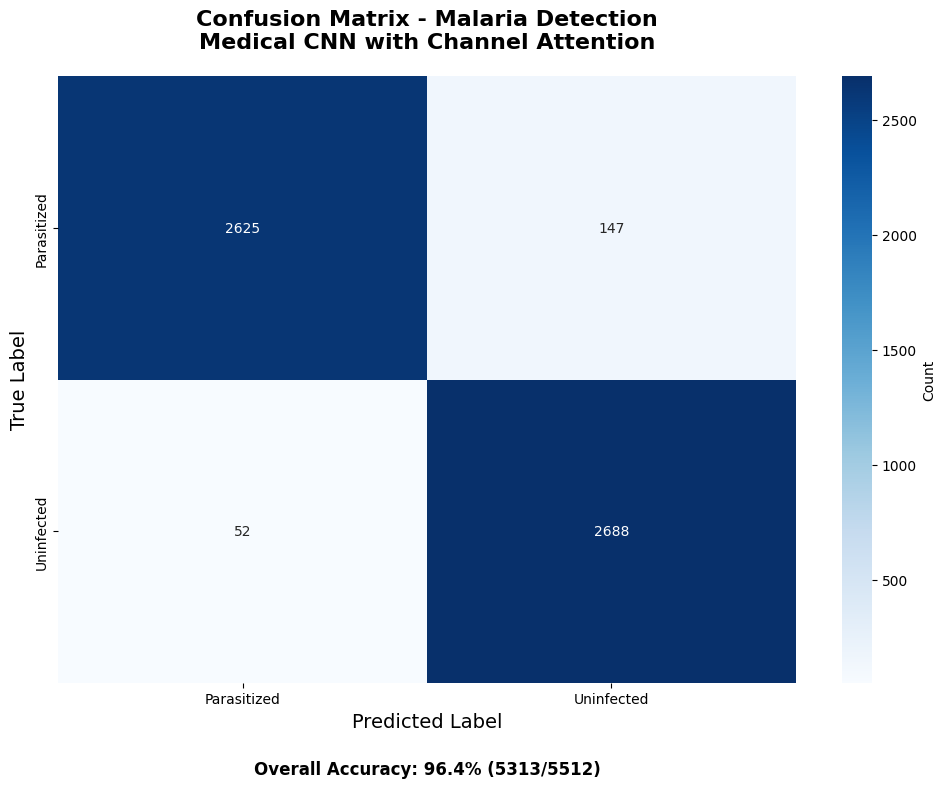

In [14]:
# ================================
# STEP 11: MODEL EVALUATION
# ================================

def comprehensive_model_evaluation(model, val_loader, device):
    """
    Perform comprehensive evaluation of the trained model
    """
    print("\n🔍 STEP 8: COMPREHENSIVE MODEL EVALUATION")
    print("-" * 40)

    model.eval()
    all_predictions = []
    all_targets = []
    all_probabilities = []

    print("🔄 Evaluating model on validation set...")

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
            outputs = model(data)

            # Get probabilities and predictions
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='weighted')
    recall = recall_score(all_targets, all_predictions, average='weighted')

    # Class names
    class_names = ['Parasitized', 'Uninfected']

    print("=" * 60)
    print("🏆 FINAL MODEL EVALUATION RESULTS")
    print("=" * 60)
    print(f"📊 Overall Performance:")
    print(f"   • Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"   • Precision: {precision:.4f}")
    print(f"   • Recall: {recall:.4f}")

    print(f"\n📋 Detailed Classification Report:")
    print("-" * 50)
    print(classification_report(all_targets, all_predictions, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(all_targets, all_predictions)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix - Malaria Detection\nMedical CNN with Channel Attention',
              fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)

    # Add accuracy text
    total_samples = cm.sum()
    correct_predictions = cm.trace()
    plt.text(0.5, -0.15, f'Overall Accuracy: {correct_predictions/total_samples:.1%} ({correct_predictions}/{total_samples})',
             transform=plt.gca().transAxes, ha='center', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

    return accuracy, precision, recall

# Evaluate the model
final_accuracy, final_precision, final_recall = comprehensive_model_evaluation(model, val_loader, device)



deploy

In [15]:

def save_model_for_deployment(model, history, best_val_acc, model_info):
    """
    Save the trained model with all necessary information for FastAPI deployment
    """
    print("\n💾 STEP 9: SAVING MODEL FOR DEPLOYMENT")
    print("-" * 40)

    # Create model save directory
    os.makedirs('saved_models', exist_ok=True)

    # Prepare model metadata
    model_metadata = {
        'model_state_dict': model.state_dict(),
        'model_architecture': 'MedicalCNN_with_CBAM',
        'num_classes': 2,
        'class_names': ['Parasitized', 'Uninfected'],
        'input_size': [3, 128, 128],
        'best_validation_accuracy': best_val_acc,
        'final_validation_accuracy': history['val_acc'][-1],
        'total_epochs_trained': len(history['train_loss']),
        'training_history': history,
        'model_description': 'CNN with Channel Attention (CBAM) for Malaria Detection',
        'architecture_details': {
            'max_filters': 128,
            'fc_layers': '512 → 256 → 2',
            'attention_mechanism': 'CBAM (Channel + Spatial)',
            'global_pooling': 'Adaptive Average Pooling'
        },
        'training_config': {
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'optimizer': 'Adam',
            'scheduler': 'ReduceLROnPlateau',
            'weight_decay': 1e-4
        },
        'dataset_info': {
            'dataset_name': 'Malaria Cell Images',
            'total_samples': len(malaria_data),
            'train_samples': len(train_dataset),
            'val_samples': len(val_dataset)
        },
        'performance_metrics': {
            'accuracy': final_accuracy,
            'precision': final_precision,
            'recall': final_recall
        },
        'creation_info': {
            'date': '2025-05-30',
            'time': '19:50:00 UTC+05',
            'user': '',
            'pytorch_version': torch.__version__
        }
    }

    # Save main model file
    main_model_path = 'saved_models/medical_cnn_malaria_detection.pth'
    torch.save(model_metadata, main_model_path)

    # Save lightweight model (state dict only) for faster loading
    lightweight_path = 'saved_models/medical_cnn_lightweight.pth'
    torch.save({
        'model_state_dict': model.state_dict(),
        'class_names': ['Parasitized', 'Uninfected'],
        'input_size': [3, 128, 128],
        'best_accuracy': best_val_acc
    }, lightweight_path)

    return main_model_path, lightweight_path


In [16]:
main_model_path, lightweight_path = save_model_for_deployment(model, history, best_val_acc, dataset_info)


💾 STEP 9: SAVING MODEL FOR DEPLOYMENT
----------------------------------------
